In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

Setting environment for Gordon


No vtk
Cannot import mxnet.


In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
from xgboost.sklearn import XGBClassifier

In [4]:
structures_to_sample = all_known_structures

negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

margins_to_sample = [500] # (100 um, 250 um)
surround_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample + ['noclass'] 
                             if surr_l != s]

labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_labels_to_sample + ['noclass']

# Extract Training Data

In [22]:
# Extract training features - random subset

training_addresses = defaultdict(list)

labels_found = set([])

# for stack in all_annotated_nissl_stacks:
# for stack in all_annotated_ntb_stacks:
for stack in ['MD594']:

    annotation_grid_indices_fn = os.path.join(ANNOTATION_ROOTDIR, stack, stack + '_annotation_grid_indices.h5')
    label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    
    labels_this_stack = set(label_gridIndices.index) & set(labels_to_sample)
    labels_found = labels_found | labels_this_stack
    
    training_addresses_sec_idx = sample_locations(label_gridIndices, labels_this_stack, 
                                                  num_samples_per_landmark=1000)
    
    for name, addresses in training_addresses_sec_idx.iteritems():
        training_addresses[name] += [(stack, ) + addr for addr in addresses]
        
training_addresses.default_factory = None
        
# sampled_addresses = {name_u: np.array(addresses) for name_u, addresses in sampled_addresses.iteritems()}

Cell is empty.
Cell is empty.
Cell is empty.


In [24]:
training_features = apply_function_to_dict(addresses_to_features, training_addresses)

('MD594', 94)
('MD594', 95)


Patch in annotation but not in mask: MD594 95 MD594-N16-2015.08.26-21.44.15_MD594_3_0048 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @145


('MD594', 96)
('MD594', 97)


Patch in annotation but not in mask: MD594 97 MD594-N17-2015.08.26-21.48.26_MD594_1_0049 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @135


('MD594', 98)
('MD594', 99)
('MD594', 100)
('MD594', 101)
('MD594', 102)
('MD594', 103)
('MD594', 104)
('MD594', 105)


Patch in annotation but not in mask: MD594 105 MD594-N18-2015.08.26-21.52.46_MD594_2_0053 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @13065
Patch in annotation but not in mask: MD594 105 MD594-N18-2015.08.26-21.52.46_MD594_2_0053 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @62


('MD594', 106)


Patch in annotation but not in mask: MD594 106 MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @98


('MD594', 107)
('MD594', 108)


Patch in annotation but not in mask: MD594 108 MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @36855
Patch in annotation but not in mask: MD594 108 MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @51


('MD594', 109)


Patch in annotation but not in mask: MD594 109 MD594-N19-2015.08.26-21.55.55_MD594_2_0056 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @12870


('MD594', 110)
('MD594', 111)
('MD594', 112)
('MD594', 113)


Patch in annotation but not in mask: MD594 113 MD594-N20-2015.08.26-21.59.11_MD594_2_0059 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @141
Patch in annotation but not in mask: MD594 113 MD594-N20-2015.08.26-21.59.11_MD594_2_0059 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @30420


('MD594', 114)
('MD594', 115)


Patch in annotation but not in mask: MD594 115 MD594-N21-2015.08.26-22.02.28_MD594_1_0061 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @32370
Patch in annotation but not in mask: MD594 115 MD594-N21-2015.08.26-22.02.28_MD594_1_0061 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @36270


('MD594', 116)
('MD594', 117)
('MD594', 118)


Patch in annotation but not in mask: MD594 118 MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @131


('MD594', 119)
('MD594', 120)


Patch in annotation but not in mask: MD594 120 MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @16380


('MD594', 121)
('MD594', 122)


Patch in annotation but not in mask: MD594 122 MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @3510


('MD594', 123)
('MD594', 124)
('MD594', 125)
('MD594', 126)
('MD594', 127)


Patch in annotation but not in mask: MD594 127 MD594-N24-2015.08.26-22.12.42_MD594_1_0070 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @47
Patch in annotation but not in mask: MD594 127 MD594-N24-2015.08.26-22.12.42_MD594_1_0070 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @194


('MD594', 128)


Patch in annotation but not in mask: MD594 128 MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @16575
Patch in annotation but not in mask: MD594 128 MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @8190


('MD594', 129)
('MD594', 130)


Patch in annotation but not in mask: MD594 130 MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @36


('MD594', 132)


Patch in annotation but not in mask: MD594 132 MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @79


('MD594', 133)
('MD594', 134)
('MD594', 135)


Patch in annotation but not in mask: MD594 135 MD594-N26-2015.08.26-22.19.23_MD594_1_0076 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @184


('MD594', 136)


Patch in annotation but not in mask: MD594 136 MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @3120
Patch in annotation but not in mask: MD594 136 MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @164


('MD594', 137)
('MD594', 138)
('MD594', 139)


Patch in annotation but not in mask: MD594 139 MD594-N27-2015.08.26-22.22.46_MD594_1_0079 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @73


('MD594', 140)


Patch in annotation but not in mask: MD594 140 MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @15795


('MD594', 141)
('MD594', 142)
('MD594', 143)
('MD594', 144)


Patch in annotation but not in mask: MD594 144 MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @54


('MD594', 145)
('MD594', 146)
('MD594', 147)
('MD594', 148)


Patch in annotation but not in mask: MD594 148 MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @13260


('MD594', 149)
('MD594', 150)
('MD594', 151)
('MD594', 152)


Patch in annotation but not in mask: MD594 152 MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @176
Patch in annotation but not in mask: MD594 152 MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @156


('MD594', 153)
('MD594', 154)
('MD594', 155)
('MD594', 156)
('MD594', 157)


Patch in annotation but not in mask: MD594 157 MD594-N31-2015.08.26-22.36.37_MD594_2_0092 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @14625


('MD594', 158)


Patch in annotation but not in mask: MD594 158 MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @27495
Patch in annotation but not in mask: MD594 158 MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @13065


('MD594', 159)


Patch in annotation but not in mask: MD594 159 MD594-N32-2015.08.26-22.40.16_MD594_1_0094 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @49
Patch in annotation but not in mask: MD594 159 MD594-N32-2015.08.26-22.40.16_MD594_1_0094 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @178
Patch in annotation but not in mask: MD594 159 MD594-N32-2015.08.26-22.40.16_MD594_1_0094 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @11115


('MD594', 160)


Patch in annotation but not in mask: MD594 160 MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @26325


('MD594', 161)


Patch in annotation but not in mask: MD594 161 MD594-N32-2015.08.26-22.40.16_MD594_2_0095 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @30030


('MD594', 162)
('MD594', 163)
('MD594', 164)


Patch in annotation but not in mask: MD594 164 MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @3705


('MD594', 165)
('MD594', 166)
('MD594', 167)


Patch in annotation but not in mask: MD594 167 MD594-N34-2015.08.26-22.47.56_MD594_1_0100 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @79
Patch in annotation but not in mask: MD594 167 MD594-N34-2015.08.26-22.47.56_MD594_1_0100 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @192


('MD594', 168)


Patch in annotation but not in mask: MD594 168 MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @30615


('MD594', 169)


Patch in annotation but not in mask: MD594 169 MD594-N34-2015.08.26-22.47.56_MD594_2_0101 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @180


('MD594', 170)


Patch in annotation but not in mask: MD594 170 MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @11895


('MD594', 171)


Patch in annotation but not in mask: MD594 171 MD594-N35-2015.08.26-22.51.43_MD594_1_0103 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @160
Patch in annotation but not in mask: MD594 171 MD594-N35-2015.08.26-22.51.43_MD594_1_0103 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @6435


('MD594', 172)


Patch in annotation but not in mask: MD594 172 MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @25545
Patch in annotation but not in mask: MD594 172 MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @4485


('MD594', 173)


Patch in annotation but not in mask: MD594 173 MD594-N35-2015.08.26-22.51.43_MD594_2_0104 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @10920


('MD594', 174)


Patch in annotation but not in mask: MD594 174 MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @91


('MD594', 175)


Patch in annotation but not in mask: MD594 175 MD594-N36-2015.08.26-22.55.28_MD594_1_0106 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @28


('MD594', 176)


Patch in annotation but not in mask: MD594 176 MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @72


('MD594', 177)
('MD594', 178)


Patch in annotation but not in mask: MD594 178 MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @27495


('MD594', 179)


Patch in annotation but not in mask: MD594 179 MD594-N37-2015.08.26-22.59.18_MD594_1_0109 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @27300
Patch in annotation but not in mask: MD594 179 MD594-N37-2015.08.26-22.59.18_MD594_1_0109 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @27885


('MD594', 180)


Patch in annotation but not in mask: MD594 180 MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @168


('MD594', 181)


Patch in annotation but not in mask: MD594 181 MD594-N37-2015.08.26-22.59.18_MD594_2_0110 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @3900


('MD594', 182)
('MD594', 183)


Patch in annotation but not in mask: MD594 183 MD594-N38-2015.08.26-23.03.12_MD594_1_0112 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @10725


('MD594', 184)


Patch in annotation but not in mask: MD594 184 MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @28
Patch in annotation but not in mask: MD594 184 MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @140


('MD594', 185)


Patch in annotation but not in mask: MD594 185 MD594-N38-2015.08.26-23.03.12_MD594_2_0113 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @27
Patch in annotation but not in mask: MD594 185 MD594-N38-2015.08.26-23.03.12_MD594_2_0113 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @28


('MD594', 186)
('MD594', 188)
('MD594', 189)


Patch in annotation but not in mask: MD594 189 MD594-N39-2015.08.26-23.07.15_MD594_2_0116 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @36
Patch in annotation but not in mask: MD594 189 MD594-N39-2015.08.26-23.07.15_MD594_2_0116 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @161
Patch in annotation but not in mask: MD594 189 MD594-N39-2015.08.26-23.07.15_MD594_2_0116 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @77


('MD594', 190)


Patch in annotation but not in mask: MD594 190 MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @124


('MD594', 191)


Patch in annotation but not in mask: MD594 191 MD594-N40-2015.08.26-23.11.10_MD594_1_0118 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @94


('MD594', 192)


Patch in annotation but not in mask: MD594 192 MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @17745


('MD594', 194)


Patch in annotation but not in mask: MD594 194 MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @81


('MD594', 195)
('MD594', 196)
('MD594', 197)
('MD594', 198)


Patch in annotation but not in mask: MD594 198 MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @34


('MD594', 199)
('MD594', 200)
('MD594', 201)
('MD594', 202)
('MD594', 203)


Patch in annotation but not in mask: MD594 203 MD594-N43-2015.08.26-23.22.56_MD594_1_0127 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @42
Patch in annotation but not in mask: MD594 203 MD594-N43-2015.08.26-23.22.56_MD594_1_0127 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @13065


('MD594', 204)


Patch in annotation but not in mask: MD594 204 MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @85
Patch in annotation but not in mask: MD594 204 MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @13065


('MD594', 205)


Patch in annotation but not in mask: MD594 205 MD594-N43-2015.08.26-23.22.56_MD594_2_0128 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @128


('MD594', 206)


Patch in annotation but not in mask: MD594 206 MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @191
Patch in annotation but not in mask: MD594 206 MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @159


('MD594', 207)


Patch in annotation but not in mask: MD594 207 MD594-N44-2015.08.26-23.26.52_MD594_1_0130 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @127


('MD594', 208)
('MD594', 209)


Patch in annotation but not in mask: MD594 209 MD594-N44-2015.08.26-23.26.52_MD594_2_0131 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @53


('MD594', 210)


Patch in annotation but not in mask: MD594 210 MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @139


('MD594', 211)


Patch in annotation but not in mask: MD594 211 MD594-N45-2015.08.26-23.30.45_MD594_1_0133 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @10530
Patch in annotation but not in mask: MD594 211 MD594-N45-2015.08.26-23.30.45_MD594_1_0133 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @36


('MD594', 212)
('MD594', 213)


Patch in annotation but not in mask: MD594 213 MD594-N45-2015.08.26-23.30.45_MD594_2_0134 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @32955
Patch in annotation but not in mask: MD594 213 MD594-N45-2015.08.26-23.30.45_MD594_2_0134 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @39


('MD594', 214)


Patch in annotation but not in mask: MD594 214 MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @24
Patch in annotation but not in mask: MD594 214 MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @14235
Patch in annotation but not in mask: MD594 214 MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @181
Patch in annotation but not in mask: MD594 214 MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @91


('MD594', 215)


Patch in annotation but not in mask: MD594 215 MD594-N46-2015.08.26-23.34.38_MD594_1_0136 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @16380


('MD594', 216)


Patch in annotation but not in mask: MD594 216 MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @50


('MD594', 217)
('MD594', 218)


Patch in annotation but not in mask: MD594 218 MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @23400


('MD594', 219)


Patch in annotation but not in mask: MD594 219 MD594-N47-2015.08.26-23.38.33_MD594_1_0139 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @23


('MD594', 220)


Patch in annotation but not in mask: MD594 220 MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @89
Patch in annotation but not in mask: MD594 220 MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @28470


('MD594', 221)


Patch in annotation but not in mask: MD594 221 MD594-N47-2015.08.26-23.38.33_MD594_2_0140 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @54
Patch in annotation but not in mask: MD594 221 MD594-N47-2015.08.26-23.38.33_MD594_2_0140 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @182


('MD594', 222)


Patch in annotation but not in mask: MD594 222 MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @14040


('MD594', 223)
('MD594', 224)


Patch in annotation but not in mask: MD594 224 MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @75


('MD594', 225)


Patch in annotation but not in mask: MD594 225 MD594-N48-2015.08.26-23.42.33_MD594_2_0143 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @39
Patch in annotation but not in mask: MD594 225 MD594-N48-2015.08.26-23.42.33_MD594_2_0143 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @32


('MD594', 226)


Patch in annotation but not in mask: MD594 226 MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @33540


('MD594', 227)


Patch in annotation but not in mask: MD594 227 MD594-N49-2015.08.26-23.46.35_MD594_1_0145 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @57


('MD594', 228)
('MD594', 229)
('MD594', 230)


Patch in annotation but not in mask: MD594 230 MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @61
Patch in annotation but not in mask: MD594 230 MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @32565


('MD594', 231)


Patch in annotation but not in mask: MD594 231 MD594-N50-2015.08.26-23.50.36_MD594_1_0148 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @135
Patch in annotation but not in mask: MD594 231 MD594-N50-2015.08.26-23.50.36_MD594_1_0148 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @26910


('MD594', 232)


Patch in annotation but not in mask: MD594 232 MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @15210


('MD594', 233)
('MD594', 234)


Patch in annotation but not in mask: MD594 234 MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @34320
Patch in annotation but not in mask: MD594 234 MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @27


('MD594', 235)


Patch in annotation but not in mask: MD594 235 MD594-N51-2015.08.26-23.54.38_MD594_1_0151 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @28


('MD594', 236)


Patch in annotation but not in mask: MD594 236 MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @24570
Patch in annotation but not in mask: MD594 236 MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @192


('MD594', 237)


Patch in annotation but not in mask: MD594 237 MD594-N51-2015.08.26-23.54.38_MD594_2_0152 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @176
Patch in annotation but not in mask: MD594 237 MD594-N51-2015.08.26-23.54.38_MD594_2_0152 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @24180


('MD594', 239)


Patch in annotation but not in mask: MD594 239 MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @54


('MD594', 240)


Patch in annotation but not in mask: MD594 240 MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @14820
Patch in annotation but not in mask: MD594 240 MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @14
Patch in annotation but not in mask: MD594 240 MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @118


('MD594', 241)
('MD594', 242)
('MD594', 243)


Patch in annotation but not in mask: MD594 243 MD594-N53-2015.08.26-23.58.45_MD594_2_0158 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @82


('MD594', 244)
('MD594', 245)
('MD594', 246)


Patch in annotation but not in mask: MD594 246 MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @108


('MD594', 247)


Patch in annotation but not in mask: MD594 247 MD594-N54-2015.08.27-00.02.48_MD594_2_0161 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @97


('MD594', 248)


Patch in annotation but not in mask: MD594 248 MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @178
Patch in annotation but not in mask: MD594 248 MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @150


('MD594', 249)


Patch in annotation but not in mask: MD594 249 MD594-N55-2015.08.27-00.06.50_MD594_1_0163 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @5850
Patch in annotation but not in mask: MD594 249 MD594-N55-2015.08.27-00.06.50_MD594_1_0163 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @67


('MD594', 250)


Patch in annotation but not in mask: MD594 250 MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @15600


('MD594', 251)


Patch in annotation but not in mask: MD594 251 MD594-N55-2015.08.27-00.06.50_MD594_2_0164 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @31785
Patch in annotation but not in mask: MD594 251 MD594-N55-2015.08.27-00.06.50_MD594_2_0164 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @34320


('MD594', 252)


Patch in annotation but not in mask: MD594 252 MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @182


('MD594', 253)


Patch in annotation but not in mask: MD594 253 MD594-N56-2015.08.27-00.10.53_MD594_1_0166 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @170


('MD594', 254)


Patch in annotation but not in mask: MD594 254 MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @5655
Patch in annotation but not in mask: MD594 254 MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @80
Patch in annotation but not in mask: MD594 254 MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @10


('MD594', 255)


Patch in annotation but not in mask: MD594 255 MD594-N56-2015.08.27-00.10.53_MD594_2_0167 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @30420


('MD594', 256)
('MD594', 257)
('MD594', 258)
('MD594', 259)


Patch in annotation but not in mask: MD594 259 MD594-N57-2015.08.27-00.14.56_MD594_2_0170 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @137


('MD594', 260)
('MD594', 262)


Patch in annotation but not in mask: MD594 262 MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @135
Patch in annotation but not in mask: MD594 262 MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @105


('MD594', 263)
('MD594', 264)


Patch in annotation but not in mask: MD594 264 MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @30810


('MD594', 265)
('MD594', 266)
('MD594', 267)
('MD594', 268)
('MD594', 269)


Patch in annotation but not in mask: MD594 269 MD594-N60-2015.08.27-00.27.50_MD594_1_0178 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @173


('MD594', 270)


Patch in annotation but not in mask: MD594 270 MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @84


('MD594', 271)


Patch in annotation but not in mask: MD594 271 MD594-N60-2015.08.27-00.27.50_MD594_2_0179 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @54


('MD594', 272)


Patch in annotation but not in mask: MD594 272 MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @115
Patch in annotation but not in mask: MD594 272 MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @86
Patch in annotation but not in mask: MD594 272 MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @30420


('MD594', 273)


Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @43454
Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @42868
Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @45797
Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @44822
Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @45799
Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @46384


('MD594', 274)
('MD594', 275)


Patch in annotation but not in mask: MD594 275 MD594-N61-2015.08.27-00.31.50_MD594_2_0182 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @6435


('MD594', 276)


Patch in annotation but not in mask: MD594 276 MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @31785


('MD594', 277)


Patch in annotation but not in mask: MD594 277 MD594-N62-2015.08.27-00.35.50_MD594_1_0184 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @7995


('MD594', 278)
('MD594', 279)


Patch in annotation but not in mask: MD594 279 MD594-N62-2015.08.27-00.35.50_MD594_2_0185 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @24960
Patch in annotation but not in mask: MD594 279 MD594-N62-2015.08.27-00.35.50_MD594_2_0185 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @13065


('MD594', 280)
('MD594', 281)


Patch in annotation but not in mask: MD594 281 MD594-N63-2015.08.27-00.39.46_MD594_1_0187 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @23


('MD594', 282)


Patch in annotation but not in mask: MD594 282 MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @88


('MD594', 283)


Patch in annotation but not in mask: MD594 283 MD594-N63-2015.08.27-00.39.46_MD594_2_0188 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @10530


('MD594', 284)


Patch in annotation but not in mask: MD594 284 MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @81


('MD594', 285)


Patch in annotation but not in mask: MD594 285 MD594-N64-2015.08.27-00.43.47_MD594_1_0190 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @75


('MD594', 286)
('MD594', 287)


Patch in annotation but not in mask: MD594 287 MD594-N64-2015.08.27-00.43.47_MD594_2_0191 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @134


('MD594', 288)


Patch in annotation but not in mask: MD594 288 MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @10


('MD594', 289)


Patch in annotation but not in mask: MD594 289 MD594-N65-2015.08.27-00.47.47_MD594_1_0193 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @8190


('MD594', 290)
('MD594', 291)


Patch in annotation but not in mask: MD594 291 MD594-N65-2015.08.27-00.47.47_MD594_2_0194 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @92


('MD594', 292)


Patch in annotation but not in mask: MD594 292 MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @3705
Patch in annotation but not in mask: MD594 292 MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @171


('MD594', 293)
('MD594', 294)


Patch in annotation but not in mask: MD594 294 MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @13260
Patch in annotation but not in mask: MD594 294 MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @148
Patch in annotation but not in mask: MD594 294 MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @83


('MD594', 295)


Patch in annotation but not in mask: MD594 295 MD594-N66-2015.08.27-00.51.38_MD594_2_0197 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @62


('MD594', 296)


Patch in annotation but not in mask: MD594 296 MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @97
Patch in annotation but not in mask: MD594 296 MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @16


('MD594', 297)


Patch in annotation but not in mask: MD594 297 MD594-N66-2015.08.27-00.51.38_MD594_3_0198 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @192


('MD594', 298)


Patch in annotation but not in mask: MD594 298 MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @39


('MD594', 299)


Patch in annotation but not in mask: MD594 299 MD594-N67-2015.08.27-00.56.36_MD594_1_0199 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @7215


('MD594', 300)
('MD594', 301)


Patch in annotation but not in mask: MD594 301 MD594-N67-2015.08.27-00.56.36_MD594_2_0200 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @26520
Patch in annotation but not in mask: MD594 301 MD594-N67-2015.08.27-00.56.36_MD594_2_0200 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @36


('MD594', 302)


Patch in annotation but not in mask: MD594 302 MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @87
Patch in annotation but not in mask: MD594 302 MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @189


('MD594', 303)


Patch in annotation but not in mask: MD594 303 MD594-N67-2015.08.27-00.56.36_MD594_3_0201 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @121
Patch in annotation but not in mask: MD594 303 MD594-N67-2015.08.27-00.56.36_MD594_3_0201 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @8970


('MD594', 304)
('MD594', 305)


Patch in annotation but not in mask: MD594 305 MD594-N68-2015.08.27-01.01.13_MD594_1_0202 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @21450


('MD594', 306)
('MD594', 307)
('MD594', 308)


Patch in annotation but not in mask: MD594 308 MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @133


('MD594', 309)
('MD594', 310)


Patch in annotation but not in mask: MD594 310 MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @17
Patch in annotation but not in mask: MD594 310 MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @108


('MD594', 311)


Patch in annotation but not in mask: MD594 311 MD594-N69-2015.08.27-01.05.43_MD594_1_0205 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @26325


('MD594', 312)
('MD594', 313)
('MD594', 314)
('MD594', 315)
('MD594', 316)


Patch in annotation but not in mask: MD594 316 MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @15
Patch in annotation but not in mask: MD594 316 MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @13


('MD594', 317)


Patch in annotation but not in mask: MD594 317 MD594-N70-2015.08.27-01.10.06_MD594_1_0208 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @12
Patch in annotation but not in mask: MD594 317 MD594-N70-2015.08.27-01.10.06_MD594_1_0208 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @5460
Patch in annotation but not in mask: MD594 317 MD594-N70-2015.08.27-01.10.06_MD594_1_0208 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @97
Patch in annotation but not in mask: MD594 317 MD594-N70-2015.08.27-01.10.06_MD594_1_0208 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @123
Patch in annotation but not in mask: MD594 317 MD594-N70-2015.08.27-01.10.06_MD594_1_0208 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @69


('MD594', 318)


Patch in annotation but not in mask: MD594 318 MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @22035


('MD594', 319)
('MD594', 320)
('MD594', 321)


Patch in annotation but not in mask: MD594 321 MD594-N70-2015.08.27-01.10.06_MD594_3_0210 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @158
Patch in annotation but not in mask: MD594 321 MD594-N70-2015.08.27-01.10.06_MD594_3_0210 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @24180


('MD594', 322)


Patch in annotation but not in mask: MD594 322 MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @70


('MD594', 323)


Patch in annotation but not in mask: MD594 323 MD594-N71-2015.08.27-01.14.30_MD594_1_0211 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @25740


('MD594', 324)
('MD594', 325)
('MD594', 326)
('MD594', 327)


Patch in annotation but not in mask: MD594 327 MD594-N71-2015.08.27-01.14.30_MD594_3_0213 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @24570
Patch in annotation but not in mask: MD594 327 MD594-N71-2015.08.27-01.14.30_MD594_3_0213 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @140


('MD594', 328)


Patch in annotation but not in mask: MD594 328 MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @29
Patch in annotation but not in mask: MD594 328 MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @29835


('MD594', 329)


Patch in annotation but not in mask: MD594 329 MD594-N72-2015.08.27-01.18.48_MD594_1_0214 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @131


('MD594', 330)


Patch in annotation but not in mask: MD594 330 MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @54


('MD594', 331)


Patch in annotation but not in mask: MD594 331 MD594-N72-2015.08.27-01.18.48_MD594_2_0215 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @102
Patch in annotation but not in mask: MD594 331 MD594-N72-2015.08.27-01.18.48_MD594_2_0215 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @10725


('MD594', 332)


Patch in annotation but not in mask: MD594 332 MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @43680


('MD594', 333)


Patch in annotation but not in mask: MD594 333 MD594-N72-2015.08.27-01.18.48_MD594_3_0216 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @34320


('MD594', 334)


Patch in annotation but not in mask: MD594 334 MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @6435


('MD594', 335)


Patch in annotation but not in mask: MD594 335 MD594-N73-2015.08.27-01.23.07_MD594_1_0217 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @37


('MD594', 336)


Patch in annotation but not in mask: MD594 336 MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @12870


('MD594', 337)
('MD594', 338)
('MD594', 339)


Patch in annotation but not in mask: MD594 339 MD594-N73-2015.08.27-01.23.07_MD594_3_0219 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @22425
Patch in annotation but not in mask: MD594 339 MD594-N73-2015.08.27-01.23.07_MD594_3_0219 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @169
Patch in annotation but not in mask: MD594 339 MD594-N73-2015.08.27-01.23.07_MD594_3_0219 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @33735


('MD594', 340)


Patch in annotation but not in mask: MD594 340 MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @194


('MD594', 342)


Patch in annotation but not in mask: MD594 342 MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @6


('MD594', 343)
('MD594', 344)
('MD594', 345)
('MD594', 346)
('MD594', 347)
('MD594', 348)


Patch in annotation but not in mask: MD594 348 MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @132
Patch in annotation but not in mask: MD594 348 MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @8


('MD594', 349)


Patch in annotation but not in mask: MD594 349 MD594-N75-2015.08.27-01.31.30_MD594_2_0224 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @9750


('MD594', 350)


Patch in annotation but not in mask: MD594 350 MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @130
Patch in annotation but not in mask: MD594 350 MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @74


('MD594', 351)
('MD594', 352)


Patch in annotation but not in mask: MD594 352 MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @51


('MD594', 353)
('MD594', 354)
('MD594', 355)
('MD594', 356)
('MD594', 357)


Patch in annotation but not in mask: MD594 357 MD594-N76-2015.08.27-01.35.41_MD594_3_0228 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @23205
Patch in annotation but not in mask: MD594 357 MD594-N76-2015.08.27-01.35.41_MD594_3_0228 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @99


('MD594', 358)
('MD594', 359)
('MD594', 360)
('MD594', 361)


Patch in annotation but not in mask: MD594 361 MD594-N77-2015.08.27-01.39.57_MD594_2_0230 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @30


('MD594', 362)
('MD594', 363)


In [25]:
# Remove addresses whose features are None

for name in labels_found:
    valid = [(ftr, addr) for ftr, addr in zip(training_features[name], training_addresses[name])
                if ftr is not None]
    res = zip(*valid)
    training_features[name] = np.array(res[0])
    training_addresses[name] = res[1]

In [26]:
for label in sorted(training_addresses.iterkeys()):
    print label, len(training_addresses[label])

10N 711
10N_negative 993
10N_surround_500_12N 1000
10N_surround_500_AP 171
10N_surround_500_noclass 1000
12N 1000
12N_negative 991
12N_surround_500_10N 692
12N_surround_500_AP 66
12N_surround_500_noclass 1000
3N 1000
3N_negative 992
3N_surround_500_4N 75
3N_surround_500_noclass 1000
4N 190
4N_negative 994
4N_surround_500_3N 168
4N_surround_500_noclass 1000
5N 1000
5N_negative 996
5N_surround_500_noclass 1000
6N 389
6N_negative 996
6N_surround_500_7n 228
6N_surround_500_noclass 1000
7N 1000
7N_negative 993
7N_surround_500_noclass 1000
7n 1000
7n_negative 995
7n_surround_500_6N 103
7n_surround_500_noclass 1000
AP 1000
AP_negative 996
AP_surround_500_10N 70
AP_surround_500_12N 88
AP_surround_500_noclass 1000
Amb 519
Amb_negative 995
Amb_surround_500_LRt 104
Amb_surround_500_noclass 1000
DC 1000
DC_negative 992
DC_surround_500_VCA 1000
DC_surround_500_VCP 1000
DC_surround_500_noclass 1000
IC 1000
IC_negative 989
IC_surround_500_SC 1000
IC_surround_500_noclass 1000
LC 1000
LC_negative 992
L

In [27]:
# Save this set as dataset.

dataset = 12

train_feat_dir = create_if_not_exists(os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_features'))

# Save training features
for label, feats in training_features.iteritems():
    bp.pack_ndarray_file(feats, os.path.join(train_feat_dir, label + '.bp'))
    
# Save training addresses
save_pickle(training_addresses, os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_addresses.pkl'))

# Load training dataset


In [56]:
# Load multiple datasets

training_features = {}

for dataset in [10, 11]:
    train_feat_dir = os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_features')
    
    for label in labels_to_sample:
        try:
            if label not in training_features:
                training_features[label] = bp.unpack_ndarray_file(os.path.join(train_feat_dir, label + '.bp'))
            else:
                training_features[label] = np.vstack([training_features[label], 
                                                     bp.unpack_ndarray_file(os.path.join(train_feat_dir, label + '.bp'))])
        except Exception as e:
            continue

In [5]:
# Load a single dataset

dataset = 2

# load training addresses
training_addresses = load_pickle(os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_addresses.pkl'))
training_addresses = {l: addrs for l, addrs in training_addresses.iteritems() if l in labels_to_sample}

# Load training features

training_features = {}
for label in labels_to_sample:
    feat_fp = os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_features', label + '.bp')
    if os.path.exists(feat_fp):
        training_features[label] = bp.unpack_ndarray_file(feat_fp)

In [ ]:
# Visualize training patches
patches = extract_patches_given_locations_multiple_sections(training_addresses['12N'][:10], 
                                                            location_or_grid_index='grid_index',
                                                            version='compressed')
display_images_in_grids(patches)

In [39]:
assert set(training_addresses.keys()) == set(training_features.keys()), \
'Training features and training addresses are not consistent.'

In [57]:
labels_found = training_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found]) - {'noclass'}

# Train Classifiers

In [58]:
setting = 26
setting_dir = os.path.join(os.path.join(CLF_ROOTDIR, 'setting_%d' % setting))
margin = 500

In [59]:
clf_dir = create_if_not_exists(os.path.join(setting_dir, 'classifiers'))

for structure in structures_found:

    print structure
    
    #############################
    ## Define Positive Samples ##
    #############################
    
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    #############################
    ## Define Negative Samples ##
    #############################
    
    if setting in [1, 3, 4, 5, 6, 7]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
    elif setting in [2, 10, 23, 24, 25, 26]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
    elif setting in [8,9,11]:
        neg_classes = [structure + '_negative']
    else:
        sys.stderr.write('Setting is not recognized.\n')

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
        
    ###########################
    ## Define Sample Weights ##
    ###########################
    
    if setting == 9:
        neg_distances = np.concatenate([distances_to_structures[neg_class][structure] for neg_class in neg_classes])
            
        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
    else:
        sample_weights = None
    
    ###########################################################################################

    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]
    
    ##################
    ## Define Model ##
    ##################
    
    if setting in [1, 2, 8, 9, 10, 11, 23, 24]:
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
            
    elif setting == 3:
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        

    elif setting == 4:
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
        
    elif setting in [5]:        
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
    elif setting in [6, 25]:
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    elif setting in [7, 26]:        
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        sys.stderr.write('Setting is not recognized.\n')

    
    t = time.time()    
    clf.fit(train_data, train_labels, sample_weight=sample_weights)
    sys.stderr.write('Fitting classifier: %.2f seconds\n' % (time.time() - t))

    joblib.dump(clf, os.path.join(clf_dir, '%(structure)s_clf_setting_%(setting)d.dump' % \
                                  dict(structure=structure, setting=setting)))

Tz
      Iter       Train Loss   Remaining Time 
         1           0.9475            1.59m
         2           0.7276            1.52m
         3           0.5927            1.48m
         4           0.5001            1.45m
         5           0.4285            1.44m
         6           0.3848            1.41m
         7           0.3431            1.39m
         8           0.3099            1.37m
         9           0.2847            1.36m
        10           0.2610            1.34m
        20           0.1351            1.18m
        30           0.0773            1.02m
        40           0.0476           52.32s
        50           0.0291           43.58s
        60           0.0185           34.78s
        70           0.0117           26.11s
        80           0.0075           17.37s
        90           0.0048            8.70s
       100           0.0031            0.00s
Sp5O


Fitting classifier: 87.52 seconds


      Iter       Train Loss   Remaining Time 
         1           1.1345            2.00m
         2           1.0383            1.97m
         3           0.9777            1.95m
         4           0.9206            1.91m
         5           0.8836            1.87m
         6           0.8452            1.84m
         7           0.8050            1.82m
         8           0.7759            1.79m
         9           0.7499            1.77m
        10           0.7362            1.73m
        20           0.5513            1.51m
        30           0.4410            1.29m
        40           0.3647            1.09m
        50           0.2917           54.52s
        60           0.2357           43.54s
        70           0.1823           32.77s
        80           0.1432           21.91s
        90           0.1184           10.91s
       100           0.0949            0.00s
7n


Fitting classifier: 110.02 seconds


      Iter       Train Loss   Remaining Time 
         1           0.9744            1.23m
         2           0.7409            1.21m
         3           0.5909            1.19m
         4           0.4909            1.18m
         5           0.4184            1.16m
         6           0.3578            1.15m
         7           0.3165            1.14m
         8           0.2859            1.12m
         9           0.2583            1.11m
        10           0.2347            1.10m
        20           0.1193           57.42s
        30           0.0647           49.75s
        40           0.0388           42.46s
        50           0.0250           35.21s
        60           0.0166           28.00s
        70           0.0109           20.95s
        80           0.0075           13.87s
        90           0.0049            6.95s
       100           0.0034            0.00s
DC


Fitting classifier: 69.75 seconds


      Iter       Train Loss   Remaining Time 
         1           0.9026            2.71m
         2           0.7794            2.69m
         3           0.6932            2.66m
         4           0.6217            2.64m
         5           0.5681            2.61m
         6           0.5212            2.58m
         7           0.4873            2.54m
         8           0.4613            2.50m
         9           0.4389            2.46m
        10           0.4183            2.42m
        20           0.2745            2.10m
        30           0.1922            1.82m
        40           0.1368            1.56m
        50           0.0958            1.30m
        60           0.0718            1.03m
        70           0.0529           46.36s
        80           0.0389           30.91s
        90           0.0279           15.47s
       100           0.0200            0.00s
5N


Fitting classifier: 155.88 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0807            1.20m
         2           0.8962            1.19m
         3           0.7770            1.18m
         4           0.6901            1.16m
         5           0.6313            1.14m
         6           0.5744            1.13m
         7           0.5249            1.12m
         8           0.4907            1.11m
         9           0.4578            1.09m
        10           0.4247            1.08m
        20           0.2522           56.25s
        30           0.1685           48.03s
        40           0.1125           40.87s
        50           0.0744           34.09s
        60           0.0524           27.01s
        70           0.0365           20.23s
        80           0.0255           13.41s
        90           0.0179            6.71s
       100           0.0125            0.00s
3N


Fitting classifier: 67.54 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0656            1.26m
         2           0.8726            1.25m
         3           0.7417            1.23m
         4           0.6493            1.22m
         5           0.5822            1.20m
         6           0.5226            1.19m
         7           0.4793            1.17m
         8           0.4382            1.16m
         9           0.4075            1.20m
        10           0.3790            1.18m
        20           0.2188            1.00m
        30           0.1385           51.17s
        40           0.0891           43.27s
        50           0.0606           35.78s
        60           0.0407           28.51s
        70           0.0274           21.39s
        80           0.0192           14.19s
        90           0.0131            7.09s
       100           0.0087            0.00s
Pn


Fitting classifier: 71.46 seconds


      Iter       Train Loss   Remaining Time 
         1           0.9707            1.94m
         2           0.8067            1.91m
         3           0.7048            1.88m
         4           0.6314            1.85m
         5           0.5747            1.83m
         6           0.5313            1.81m
         7           0.4976            1.77m
         8           0.4676            1.75m
         9           0.4423            1.73m
        10           0.4204            1.70m
        20           0.2785            1.49m
        30           0.1919            1.29m
        40           0.1348            1.10m
        50           0.0950           55.12s
        60           0.0670           44.16s
        70           0.0494           33.08s
        80           0.0364           22.07s
        90           0.0272           11.05s
       100           0.0205            0.00s
10N


Fitting classifier: 111.35 seconds


      Iter       Train Loss   Remaining Time 
         1           0.9065            1.90m
         2           0.7268            1.93m
         3           0.6043            1.91m
         4           0.5150            1.90m
         5           0.4476            1.86m
         6           0.3983            1.83m
         7           0.3588            1.81m
         8           0.3259            1.79m
         9           0.2980            1.76m
        10           0.2752            1.74m
        20           0.1389            1.54m
        30           0.0826            1.33m
        40           0.0497            1.13m
        50           0.0308           56.45s
        60           0.0190           45.07s
        70           0.0117           33.79s
        80           0.0074           22.50s
        90           0.0047           11.24s
       100           0.0030            0.00s
LC


Fitting classifier: 112.99 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0776            1.20m
         2           0.8981            1.18m
         3           0.7718            1.16m
         4           0.6875            1.14m
         5           0.6160            1.13m
         6           0.5636            1.12m
         7           0.5188            1.10m
         8           0.4840            1.09m
         9           0.4600            1.07m
        10           0.4357            1.05m
        20           0.2581           54.91s
        30           0.1583           47.64s
        40           0.0957           41.06s
        50           0.0623           33.99s
        60           0.0431           27.01s
        70           0.0289           20.19s
        80           0.0200           13.44s
        90           0.0138            6.72s
       100           0.0092            0.00s
7N


Fitting classifier: 67.78 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0526            1.22m
         2           0.8496            1.21m
         3           0.7219            1.19m
         4           0.6284            1.17m
         5           0.5603            1.16m
         6           0.5129            1.14m
         7           0.4705            1.13m
         8           0.4349            1.12m
         9           0.4051            1.10m
        10           0.3774            1.09m
        20           0.2191           56.56s
        30           0.1302           48.98s
        40           0.0819           41.72s
        50           0.0543           34.23s
        60           0.0354           27.39s
        70           0.0240           20.53s
        80           0.0155           13.70s
        90           0.0106            6.82s
       100           0.0071            0.00s
Amb


Fitting classifier: 68.65 seconds


      Iter       Train Loss   Remaining Time 
         1           0.8821           51.82s
         2           0.6681           51.60s
         3           0.5309           50.96s
         4           0.4447           49.71s
         5           0.3724           49.14s
         6           0.3257           48.23s
         7           0.2908           47.35s
         8           0.2554           47.12s
         9           0.2320           46.27s
        10           0.2104           45.73s
        20           0.0922           40.58s
        30           0.0454           35.66s
        40           0.0233           30.46s
        50           0.0120           25.42s
        60           0.0069           20.19s
        70           0.0037           15.14s
        80           0.0021           10.10s
        90           0.0012            5.04s
       100           0.0007            0.00s
12N


Fitting classifier: 50.61 seconds


      Iter       Train Loss   Remaining Time 
         1           0.8851            1.99m
         2           0.6772            1.85m
         3           0.5459            1.79m
         4           0.4538            1.75m
         5           0.3880            1.72m
         6           0.3411            1.69m
         7           0.3010            1.67m
         8           0.2684            1.65m
         9           0.2417            1.63m
        10           0.2220            1.61m
        20           0.1133            1.42m
        30           0.0659            1.23m
        40           0.0398            1.05m
        50           0.0255           52.37s
        60           0.0154           42.02s
        70           0.0097           31.44s
        80           0.0063           20.92s
        90           0.0041           10.44s
       100           0.0027            0.00s
RMC


Fitting classifier: 104.87 seconds


      Iter       Train Loss   Remaining Time 
         1           1.1493            1.20m
         2           1.0048            1.18m
         3           0.9067            1.17m
         4           0.8300            1.15m
         5           0.7641            1.15m
         6           0.7173            1.14m
         7           0.6728            1.12m
         8           0.6320            1.11m
         9           0.6019            1.09m
        10           0.5688            1.08m
        20           0.3838           55.50s
        30           0.2719           47.58s
        40           0.2035           40.00s
        50           0.1425           33.46s
        60           0.1028           26.95s
        70           0.0778           20.05s
        80           0.0562           13.38s
        90           0.0420            6.70s
       100           0.0313            0.00s
VCA


Fitting classifier: 67.29 seconds


      Iter       Train Loss   Remaining Time 
         1           0.8734            2.68m
         2           0.7458            2.64m
         3           0.6648            2.62m
         4           0.6058            2.59m
         5           0.5572            2.56m
         6           0.5159            2.53m
         7           0.4855            2.49m
         8           0.4602            2.46m
         9           0.4358            2.43m
        10           0.4173            2.40m
        20           0.2890            2.10m
        30           0.2113            1.81m
        40           0.1592            1.55m
        50           0.1203            1.28m
        60           0.0903            1.02m
        70           0.0673           46.04s
        80           0.0512           30.66s
        90           0.0405           15.31s
       100           0.0317            0.00s
Sp5I


Fitting classifier: 153.82 seconds


      Iter       Train Loss   Remaining Time 
         1           0.9592            2.73m
         2           0.8640            2.68m
         3           0.7978            2.66m
         4           0.7462            2.62m
         5           0.7053            2.58m
         6           0.6780            2.54m
         7           0.6491            2.50m
         8           0.6250            2.47m
         9           0.6079            2.43m
        10           0.5838            2.41m
        20           0.4447            2.08m
        30           0.3546            1.79m
        40           0.2805            1.53m
        50           0.2277            1.27m
        60           0.1870            1.01m
        70           0.1507           45.44s
        80           0.1208           30.34s
        90           0.0975           15.21s
       100           0.0802            0.00s
Sp5C


Fitting classifier: 153.11 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0995            1.97m
         2           0.9926            1.94m
         3           0.9172            1.91m
         4           0.8548            1.89m
         5           0.8115            1.86m
         6           0.7677            1.85m
         7           0.7380            1.82m
         8           0.7075            1.80m
         9           0.6822            1.77m
        10           0.6536            1.75m
        20           0.4827            1.52m
        30           0.3737            1.30m
        40           0.2938            1.10m
        50           0.2355           54.76s
        60           0.1849           43.75s
        70           0.1487           32.79s
        80           0.1160           21.90s
        90           0.0940           10.92s
       100           0.0756            0.00s
4N


Fitting classifier: 109.76 seconds


      Iter       Train Loss   Remaining Time 
         1           0.4059           44.00s
         2           0.3386           41.55s
         3           0.2873           40.46s
         4           0.2416           41.96s
         5           0.2070           41.28s
         6           0.1808           41.13s
         7           0.1562           40.56s
         8           0.1433           39.63s
         9           0.1245           39.67s
        10           0.1078           39.62s
        20           0.0415           34.10s
        30           0.0165           30.07s
        40           0.0068           25.82s
        50           0.0029           21.46s
        60           0.0014           17.09s
        70           0.0006           12.80s
        80           0.0003            8.38s
        90           0.0003            3.82s
       100           0.0003            0.00s
AP


Fitting classifier: 34.70 seconds


      Iter       Train Loss   Remaining Time 
         1           0.9604            1.18m
         2           0.7201            1.16m
         3           0.5621            1.14m
         4           0.4546            1.14m
         5           0.3772            1.12m
         6           0.3185            1.10m
         7           0.2700            1.09m
         8           0.2312            1.08m
         9           0.2046            1.07m
        10           0.1806            1.06m
        20           0.0769           55.82s
        30           0.0390           48.01s
        40           0.0215           41.06s
        50           0.0126           34.12s
        60           0.0073           27.29s
        70           0.0040           20.53s
        80           0.0023           13.70s
        90           0.0013            6.85s
       100           0.0007            0.00s
PBG


Fitting classifier: 69.02 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0079            1.14m
         2           0.7960            1.13m
         3           0.6527            1.13m
         4           0.5515            1.12m
         5           0.4785            1.11m
         6           0.4163            1.10m
         7           0.3746            1.09m
         8           0.3330            1.08m
         9           0.3054            1.06m
        10           0.2817            1.05m
        20           0.1385           54.71s
        30           0.0748           47.54s
        40           0.0433           40.75s
        50           0.0253           33.98s
        60           0.0157           26.98s
        70           0.0096           20.21s
        80           0.0057           13.48s
        90           0.0036            6.71s
       100           0.0023            0.00s
LRt


Fitting classifier: 67.41 seconds


      Iter       Train Loss   Remaining Time 
         1           1.1066            1.23m
         2           0.9362            1.22m
         3           0.8168            1.21m
         4           0.7319            1.20m
         5           0.6672            1.19m
         6           0.6240            1.17m
         7           0.5764            1.16m
         8           0.5372            1.14m
         9           0.5050            1.13m
        10           0.4829            1.10m
        20           0.2965           57.53s
        30           0.1997           49.45s
        40           0.1364           41.95s
        50           0.0936           34.83s
        60           0.0669           27.69s
        70           0.0468           20.75s
        80           0.0340           13.77s
        90           0.0247            6.87s
       100           0.0178            0.00s
IC


Fitting classifier: 68.97 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0862            1.95m
         2           0.9741            1.93m
         3           0.8962            1.91m
         4           0.8317            1.89m
         5           0.7850            1.86m
         6           0.7448            1.84m
         7           0.7096            1.82m
         8           0.6786            1.80m
         9           0.6532            1.77m
        10           0.6291            1.75m
        20           0.4580            1.51m
        30           0.3640            1.29m
        40           0.2872            1.10m
        50           0.2232           54.75s
        60           0.1732           43.81s
        70           0.1392           32.69s
        80           0.1058           21.86s
        90           0.0826           10.93s
       100           0.0676            0.00s
VLL


Fitting classifier: 109.76 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0747            1.23m
         2           0.8886            1.21m
         3           0.7701            1.19m
         4           0.6781            1.18m
         5           0.6139            1.16m
         6           0.5608            1.15m
         7           0.5276            1.13m
         8           0.4906            1.12m
         9           0.4659            1.10m
        10           0.4395            1.09m
        20           0.2764           56.65s
        30           0.1738           48.84s
        40           0.1185           41.64s
        50           0.0836           34.42s
        60           0.0603           27.24s
        70           0.0399           20.53s
        80           0.0290           13.67s
        90           0.0205            6.82s
       100           0.0141            0.00s
VCP


Fitting classifier: 68.85 seconds


      Iter       Train Loss   Remaining Time 
         1           0.9480            2.62m
         2           0.8442            2.63m
         3           0.7709            2.62m
         4           0.7153            2.60m
         5           0.6698            2.58m
         6           0.6306            2.55m
         7           0.5985            2.52m
         8           0.5663            2.48m
         9           0.5438            2.44m
        10           0.5204            2.41m
        20           0.3504            2.14m
        30           0.2555            1.85m
        40           0.1923            1.57m
        50           0.1461            1.30m
        60           0.1117            1.04m
        70           0.0840           46.61s
        80           0.0643           31.10s
        90           0.0500           15.53s
       100           0.0384            0.00s
SNC


Fitting classifier: 156.77 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0340            1.96m
         2           0.8985            1.92m
         3           0.8099            1.89m
         4           0.7400            1.86m
         5           0.6860            1.84m
         6           0.6462            1.81m
         7           0.6140            1.79m
         8           0.5846            1.76m
         9           0.5561            1.74m
        10           0.5264            1.72m
        20           0.3629            1.49m
        30           0.2674            1.29m
        40           0.2018            1.09m
        50           0.1506           54.39s
        60           0.1135           43.40s
        70           0.0845           32.58s
        80           0.0656           21.68s
        90           0.0485           10.86s
       100           0.0363            0.00s
6N


Fitting classifier: 109.54 seconds


      Iter       Train Loss   Remaining Time 
         1           0.5862           38.44s
         2           0.4606           37.14s
         3           0.3806           36.44s
         4           0.3233           35.86s
         5           0.2729           35.79s
         6           0.2369           35.33s
         7           0.2041           35.19s
         8           0.1838           34.68s
         9           0.1565           34.86s
        10           0.1397           34.66s
        20           0.0495           30.97s
        30           0.0201           27.35s
        40           0.0093           23.59s
        50           0.0046           19.79s
        60           0.0029           15.79s
        70           0.0019           11.81s
        80           0.0015            7.85s
        90           0.0013            3.82s
       100           0.0013            0.00s
SNR


Fitting classifier: 36.24 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0705            2.00m
         2           0.9493            1.98m
         3           0.8530            1.97m
         4           0.7799            1.95m
         5           0.7238            1.93m
         6           0.6753            1.90m
         7           0.6377            1.88m
         8           0.6005            1.85m
         9           0.5716            1.83m
        10           0.5453            1.80m
        20           0.3642            1.57m
        30           0.2662            1.35m
        40           0.2013            1.14m
        50           0.1524           56.71s
        60           0.1119           45.37s
        70           0.0821           34.11s
        80           0.0629           22.66s
        90           0.0479           11.32s
       100           0.0368            0.00s
SC


Fitting classifier: 113.96 seconds


      Iter       Train Loss   Remaining Time 
         1           1.1540            1.95m
         2           1.0716            1.93m
         3           1.0151            1.90m
         4           0.9704            1.86m
         5           0.9265            1.84m
         6           0.8924            1.82m
         7           0.8632            1.80m
         8           0.8367            1.77m
         9           0.8147            1.74m
        10           0.7872            1.72m
        20           0.6071            1.49m
        30           0.4866            1.29m
        40           0.4053            1.09m
        50           0.3214           54.48s
        60           0.2604           43.49s
        70           0.2143           32.51s
        80           0.1720           21.68s
        90           0.1398           10.82s
       100           0.1103            0.00s
RtTg


Fitting classifier: 109.36 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0232            2.16m
         2           0.9124            2.09m
         3           0.8316            2.07m
         4           0.7732            2.03m
         5           0.7245            2.02m
         6           0.6787            2.00m
         7           0.6412            1.98m
         8           0.6131            1.96m
         9           0.5900            1.93m
        10           0.5677            1.90m
        20           0.4214            1.64m
        30           0.3217            1.41m
        40           0.2401            1.21m
        50           0.1837            1.01m
        60           0.1465           48.49s
        70           0.1160           36.40s
        80           0.0950           24.23s
        90           0.0793           12.10s
       100           0.0670            0.00s


Fitting classifier: 121.96 seconds


# Load pre-computed classifiers

In [60]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = os.path.join(setting_dir, 'classifiers', '%(structure)s_clf_setting_%(setting)d.dump' % {'structure': structure, 'setting':setting})
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('No classifier for %s is found.\n' % structure)

No classifier for sp5 is found.
No classifier for outerContour is found.


In [61]:
margin = 500

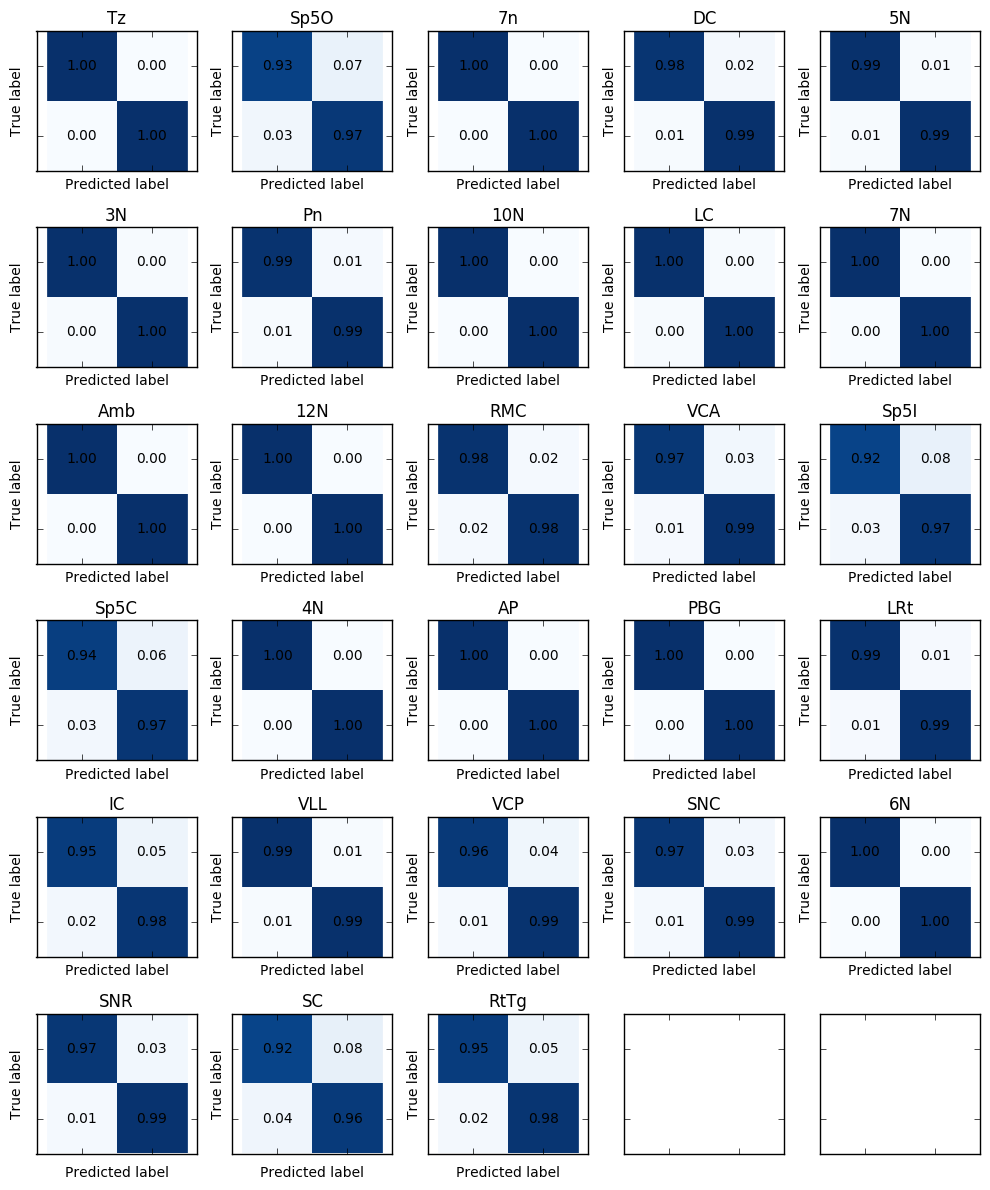

In [62]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    if setting in [1, 3, 4, 5, 6, 7]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
    elif setting in [2, 10, 23, 24, 25, 26]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]            
        for surr_l in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_l)
            if c in labels_found:
                neg_classes.append(c)
    elif setting in [8,9,11]:
        neg_classes = [structure + '_negative']
    else:
        sys.stderr.write('Setting is not recognized.\n')
        raise

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
#     neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(train_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s'% {'structure':structure},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [63]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.986382926511


In [ ]:
# visualize training patches

patches = extract_patches_given_locations_multiple_sections(sampled_addresses['AP'], 'grid_index')
display_images_in_grids(patches, 5)

patches = extract_patches_given_locations_multiple_sections(sampled_addresses['AP_surround'], 'grid_index')
display_images_in_grids(patches, 5, titles=sampled_addresses['AP_surround'])

# Visualize a patch in context

patch_size, stride, _, _ = get_default_gridspec('MD589')
grid_locations = grid_parameters_to_sample_locations(get_default_gridspec('MD589'))
viz = patch_boxes_overlay_on('original', 8, 
                       [grid_locations[44453]],
                      patch_size=patch_size,
                      stack='MD589',
                       sec=219)
display_image(viz)